In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

In [3]:
ds = xr.open_dataset("gs://cmip6/GFDL_CM2_6/control/ocean_3d", engine='zarr', chunks={}, use_cftime=True)
param = xr.open_dataset("gs://cmip6/GFDL_CM2_6/grid", engine='zarr')

In [4]:
import gsw

# Computing Nsquared
The Nsquared interface requires:
* Absolute Salinity, g/kg
* Conservative Temperature (ITS-90), degrees C
* Sea pressure (absolute pressure minus 10.1325 dbar), dbar

The CM2.6 dataset provides:
* Potential temperature, degrees C
* Practical Salinity, psu

In [5]:
SP = ds['salt'] # Practical salinity
PT = ds['temp'] # Potential temperature

In [6]:
# Note that we pass the negative depth because the axis is upward in this function
# The output is almost similar to depth in metres
P = gsw.p_from_z(-param.st_ocean, param.yt_ocean).chunk() # sea pressure ( i.e. absolute pressure - 10.1325 dbar )

In [7]:
Z = param.st_ocean.expand_dims({'yt_ocean': param.yt_ocean})

Text(0, 0.5, 'Sea pressure in dbar')

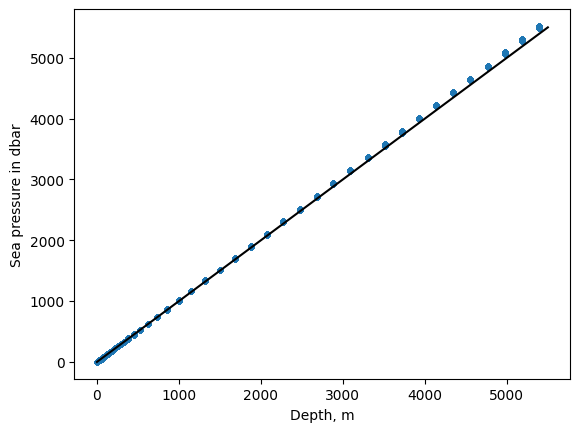

In [13]:
plt.plot(Z.values.ravel(),P.T.values.ravel(), '.');
plt.plot([0,5500],[0,5500],'k')
plt.xlabel('Depth, m')
plt.ylabel('Sea pressure in dbar')

In [8]:
# Note here we provide longitude in a range -280..80, and it is OK. We
# still can target Baltic sea, which is a purpose of this input parameter
# The output is almost similar to Practical Salinity
SA = gsw.SA_from_SP(SP, P, param.xt_ocean, param.yt_ocean) # Absolute Salinity

In [18]:
plt.plot(SP[0][10].values.ravel(), SA[0][10].values.ravel(), '.')
plt.plot([0,60], [0,60], 'k')
plt.xlabel('Practical Salinity, psu')
plt.ylabel('Absolute Salinity, g/kg')

Text(0, 0.5, 'Absolute Salinity, g/kg')

In [9]:
# Note the output is almost identical
CT = gsw.CT_from_pt(SA, PT) # Conservative temperature, in degrees

In [22]:
plt.plot(PT[0][10].values.ravel(), CT[0][10].values.ravel(), '.')
plt.plot([0,60], [0,60], 'k')
plt.xlabel('Potential Temperature, C')
plt.ylabel('Conservative Temperature, C')

Text(0, 0.5, 'Conservative Temperature, C')

# Check vertical profile

In [48]:
CT[0][0].plot()

In [10]:
def select(x):
    y=x
    if 'xt_ocean' in x.dims:
        y = y.sel(xt_ocean=-149.95, method='nearest')
    if 'yt_ocean' in x.dims:
        y = y.sel(yt_ocean=0.0, method='nearest')

    if 'time' in x.dims:
        y = y.isel(time=0)
    return y

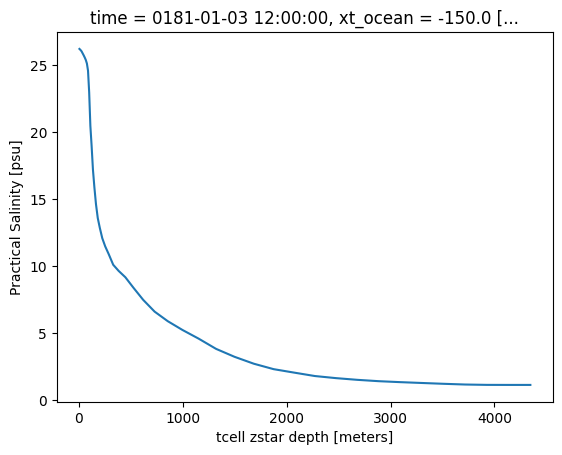

In [11]:
select(CT).plot()

In [12]:
N2 = gsw.Nsquared(select(SA), select(CT), select(P), axis=0)

In [13]:
# So the only vertical coordinate used here is the sea level pressure in dbars
N2_val = gsw.Nsquared(select(SA).values, select(CT).values, select(P).values, axis=0)

In [14]:
(N2_val[0]-N2[0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

In [15]:
plt.plot(N2[1], N2[0])
plt.axhline(y=0, color='k')

# In-situ density calculated with zero pressure is the potential density

In [16]:
rho = gsw.rho(select(SA), select(CT), select(P))
rho0 = gsw.rho(select(SA), select(CT), 0.)
rho_lazy = gsw.rho(select(SP), select(PT), 0.)
sigma0p = (1000.+gsw.sigma0(select(SA), select(CT)))

In [17]:
(rho0-sigma0p).values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

In [18]:
(rho_lazy-sigma0p).values

array([-0.12197591, -0.12209987, -0.12238848, -0.12296153, -0.12359271,
       -0.12430327, -0.12505459, -0.12591813, -0.12713057, -0.12925056,
       -0.1308847 , -0.13127159, -0.1314391 , -0.13130373, -0.13079422,
       -0.13021478, -0.12995158, -0.12988835, -0.1298882 , -0.12991301,
       -0.13009341, -0.13035144, -0.13074894, -0.13127981, -0.13216479,
       -0.13327509, -0.13442962, -0.13561363, -0.13686913, -0.13821694,
       -0.13949545, -0.14031922, -0.14101364, -0.14156824, -0.14205964,
       -0.14236231, -0.1425869 , -0.14273182, -0.14279102, -0.14280134,
       -0.14277095, -0.14269629, -0.14256094, -0.14240477, -0.14223143,
               nan,         nan,         nan,         nan,         nan])

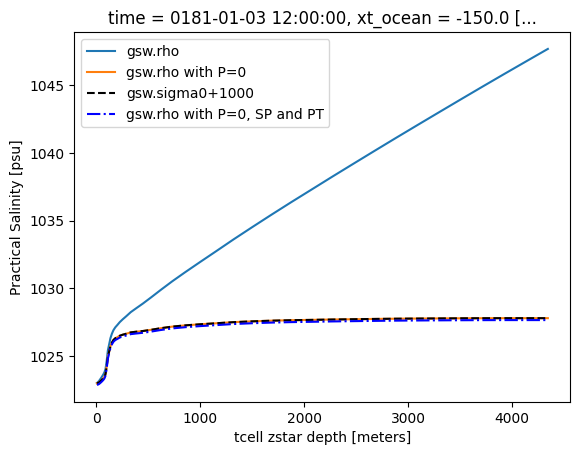

In [19]:
rho.plot(label='gsw.rho')
rho0.plot(label='gsw.rho with P=0')
sigma0p.plot(label='gsw.sigma0+1000', ls='--', color='k')
rho_lazy.plot(label='gsw.rho with P=0, SP and PT', ls='-.', color='b')
plt.legend()

In [20]:
drhodz = rho_lazy.chunk({'st_ocean':-1}).differentiate('st_ocean')
N2_lazy = (9.8*drhodz/1025)

drhodz = rho_lazy.chunk({'st_ocean':-1}).diff('st_ocean') / rho_lazy.st_ocean.diff('st_ocean')
drhodz['st_ocean'] = rho_lazy.st_ocean.rolling(st_ocean=2).mean()[1:]
N2_FD = (9.8*drhodz/1025)

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate = (9.8*drhodz/1025)

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate2 = (9.7963*drhodz/1025) # Value of g is from https://www.teos-10.org/pubs/gsw/html/gsw_Nsquared.html

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate3 = 9.7963*drhodz/sigma0p.rolling(st_ocean=2).mean()[1:].drop_vars('st_ocean')

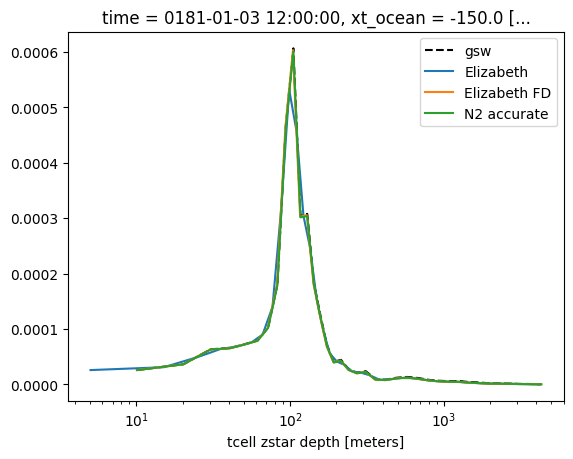

In [21]:
plt.plot(N2[1], N2[0], ls='--', label='gsw', color='k')
N2_lazy.plot(label='Elizabeth')
N2_FD.plot(label='Elizabeth FD')
N2_accurate.plot(label='N2 accurate')
plt.xscale('log')
plt.legend()

In [22]:
np.nanmean((N2[0]-N2_FD.values)**2)

1.3553284829440233e-12

In [23]:
np.nanmean((N2[0]-N2_accurate.values)**2)

2.6983518569707043e-12

In [24]:
np.nanmean((N2[0]-N2_accurate2.values)**2)

2.8529452714523265e-12

In [25]:
np.nanmean((N2[0]-N2_accurate3.values)**2)

2.7975598594687857e-12

## Conclusions of this study on TEOS-10:
* New variables for temperature, salinity and pressure (close to depth) do not change significantly prediction of density
* The most impact is oserved for considering in-situ vs conservative density. sigma0 is the potential density which should be used for N2 computation
* Reference values for g and density used by Elizabeth without conversion of T,S,P are more accurate then any other empirical formulas for N2.

# Including Nsquared computations into CM26 dataset structure

In [28]:
%%time 
ds = DatasetCM26(source='cmip6-3d')

CPU times: user 29 s, sys: 10.4 s, total: 39.4 s
Wall time: 38.2 s


In [26]:
# coarse = ds.coarsen()

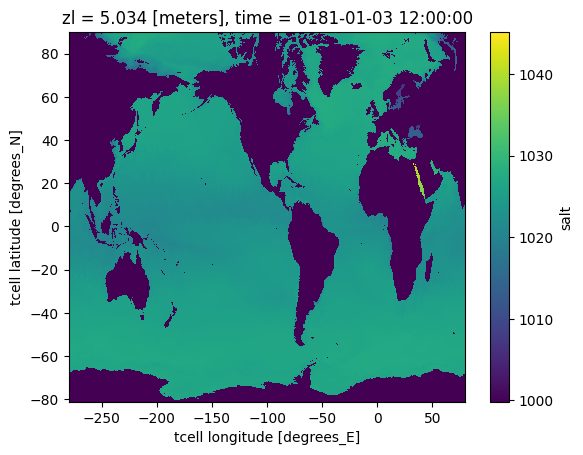

In [27]:
ds.state.rho.isel(time=0,zl=0).plot()

In [132]:
%%time 
test = select(ds.state.Nsquared.rename({'xh': 'xt_ocean', 'yh': 'yt_ocean'})).compute()

CPU times: user 24.9 s, sys: 9.17 s, total: 34.1 s
Wall time: 19.8 s


In [133]:
(test[1:-1].values-N2_FD.values)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

In [134]:
%time cg = ds.state.baroclinic_speed.isel(time=0).compute();

CPU times: user 27.3 s, sys: 10.8 s, total: 38.1 s
Wall time: 23.9 s


In [135]:
%time Rd = ds.state.deformation_radius.isel(time=0).compute()

CPU times: user 28 s, sys: 11.1 s, total: 39.1 s
Wall time: 24.5 s


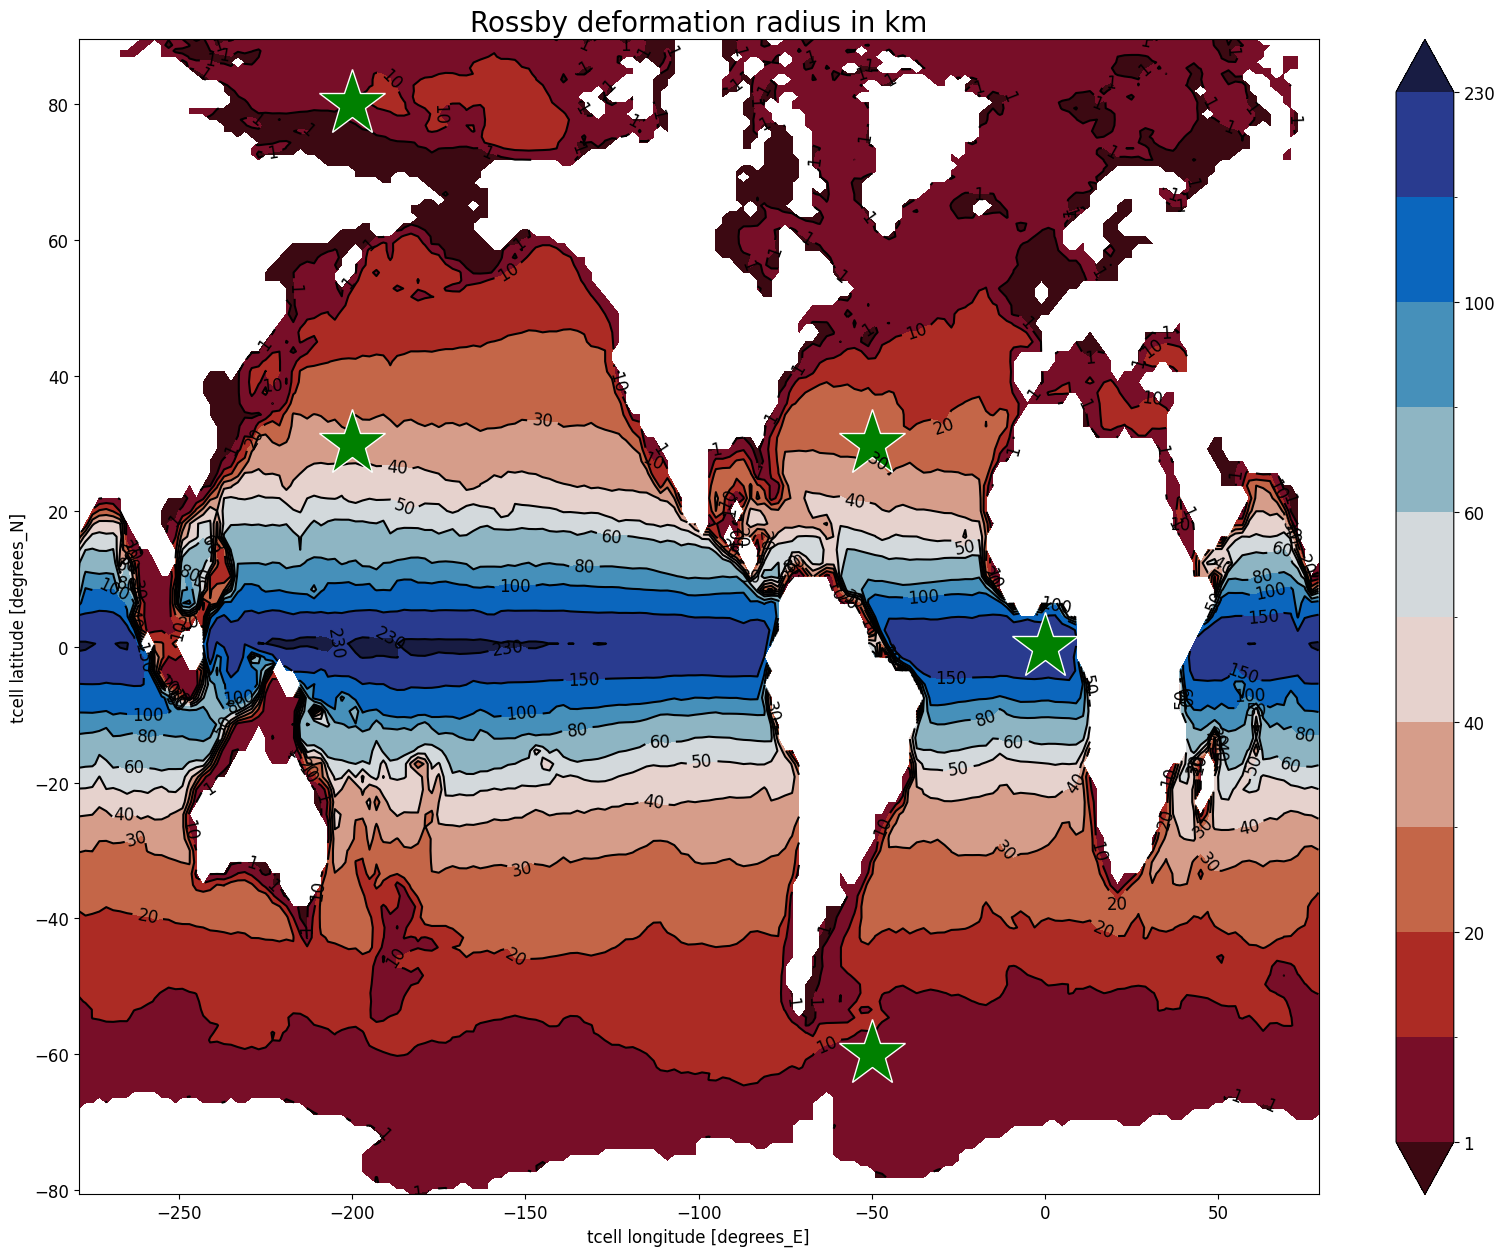

In [142]:
plt.figure(figsize=(20,15))
import cmocean
mask = ds.param.wet[0]
mask = np.where(mask,1,np.nan)

Rdc = (Rd*1e-3*mask).coarsen({'xh':20, 'yh':20}).mean()

(Rdc).plot.contourf(levels=[1,10, 20, 30, 40, 50, 60, 80, 100, 150, 230], cmap=cmocean.cm.balance.reversed(),extend='both')
CS = (Rdc).plot.contour(levels=[1,10, 20, 30, 40, 50, 60, 80, 100, 150, 230], colors='k')
plt.clabel(CS)
plt.plot(0,0, '*g',markersize=50, markeredgecolor='w')
plt.plot(-200, 30, '*g',markersize=50, markeredgecolor='w')
plt.plot(-50, 30, '*g',markersize=50, markeredgecolor='w')
plt.plot(-50, -60, '*g',markersize=50, markeredgecolor='w')
plt.plot(-200, 80, '*g',markersize=50, markeredgecolor='w')
plt.title('Rossby deformation radius in km', fontsize=20)
plt.savefig('Deformation.pdf',bbox_inches='tight')

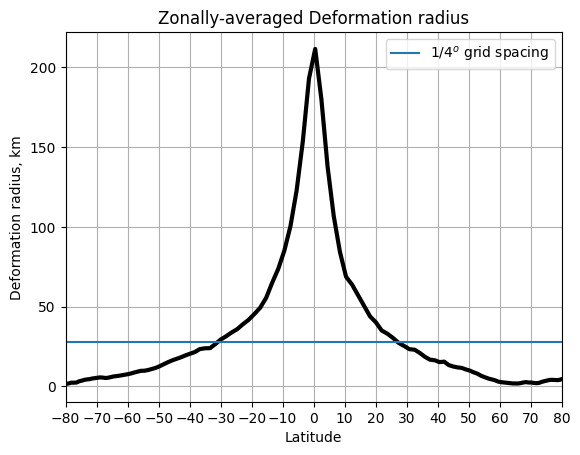

In [136]:
Rdc.mean('xh').plot(color='k', lw=3)
plt.ylabel('Deformation radius, km')
plt.xlabel('Latitude')
plt.title('Zonally-averaged Deformation radius')
plt.xticks(np.arange(-80,100,10));
plt.xlim([-80, 80])
dx = 40000/360/4 # of 1/4 degree model
plt.axhline(y=dx, color='tab:blue', label='$1/4^o$ grid spacing')
plt.grid()
plt.legend()

In [32]:
%time Rd_dx = ds.state.Rd_dx.isel(time=0).compute()

CPU times: user 27.4 s, sys: 11.4 s, total: 38.8 s
Wall time: 24.1 s


Text(0.5, 1.0, 'Rossby deformation radius divided by the grid step for CM2.6')

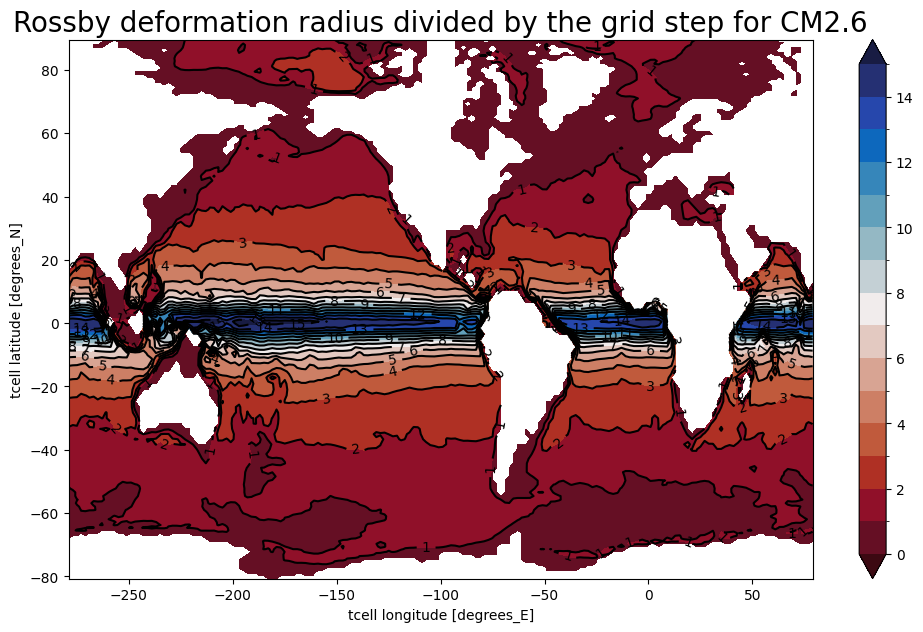

In [33]:
plt.figure(figsize=(12,7))
import cmocean
mask = ds.param.wet[0]
mask = np.where(mask,1,np.nan)

Rdc = (Rd_dx*mask).coarsen({'xh':20, 'yh':20}).mean()

(Rdc).plot.contourf(levels=np.arange(0,16), cmap=cmocean.cm.balance.reversed(),extend='both')
CS = (Rdc).plot.contour(levels=np.arange(0,16), colors='k')
plt.clabel(CS)
plt.title('Rossby deformation radius divided by the grid step for CM2.6', fontsize=20)

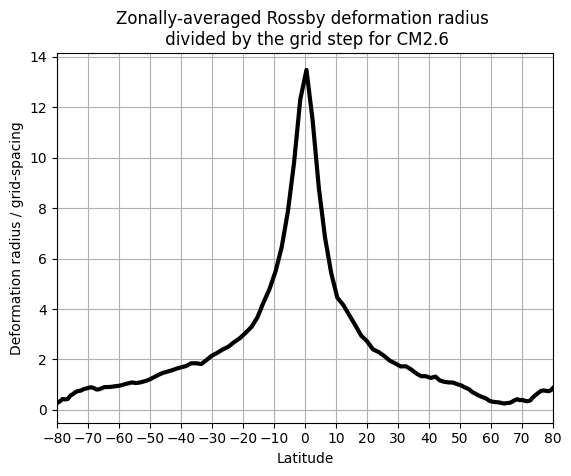

In [34]:
Rdc.mean('xh').plot(color='k', lw=3)
plt.ylabel('Deformation radius / grid-spacing')
plt.xlabel('Latitude')
plt.title('Zonally-averaged Rossby deformation radius \n divided by the grid step for CM2.6')
plt.xticks(np.arange(-80,100,10));
plt.xlim([-80, 80])
plt.grid()

In [35]:
Ro = ds.state.rossby_number.isel(time=0).compute()

In [36]:
mask = np.where(ds.param.wet,1,np.nan)
ro = (Ro  * mask).coarsen({'xh': 5, 'yh': 5}).mean().compute()

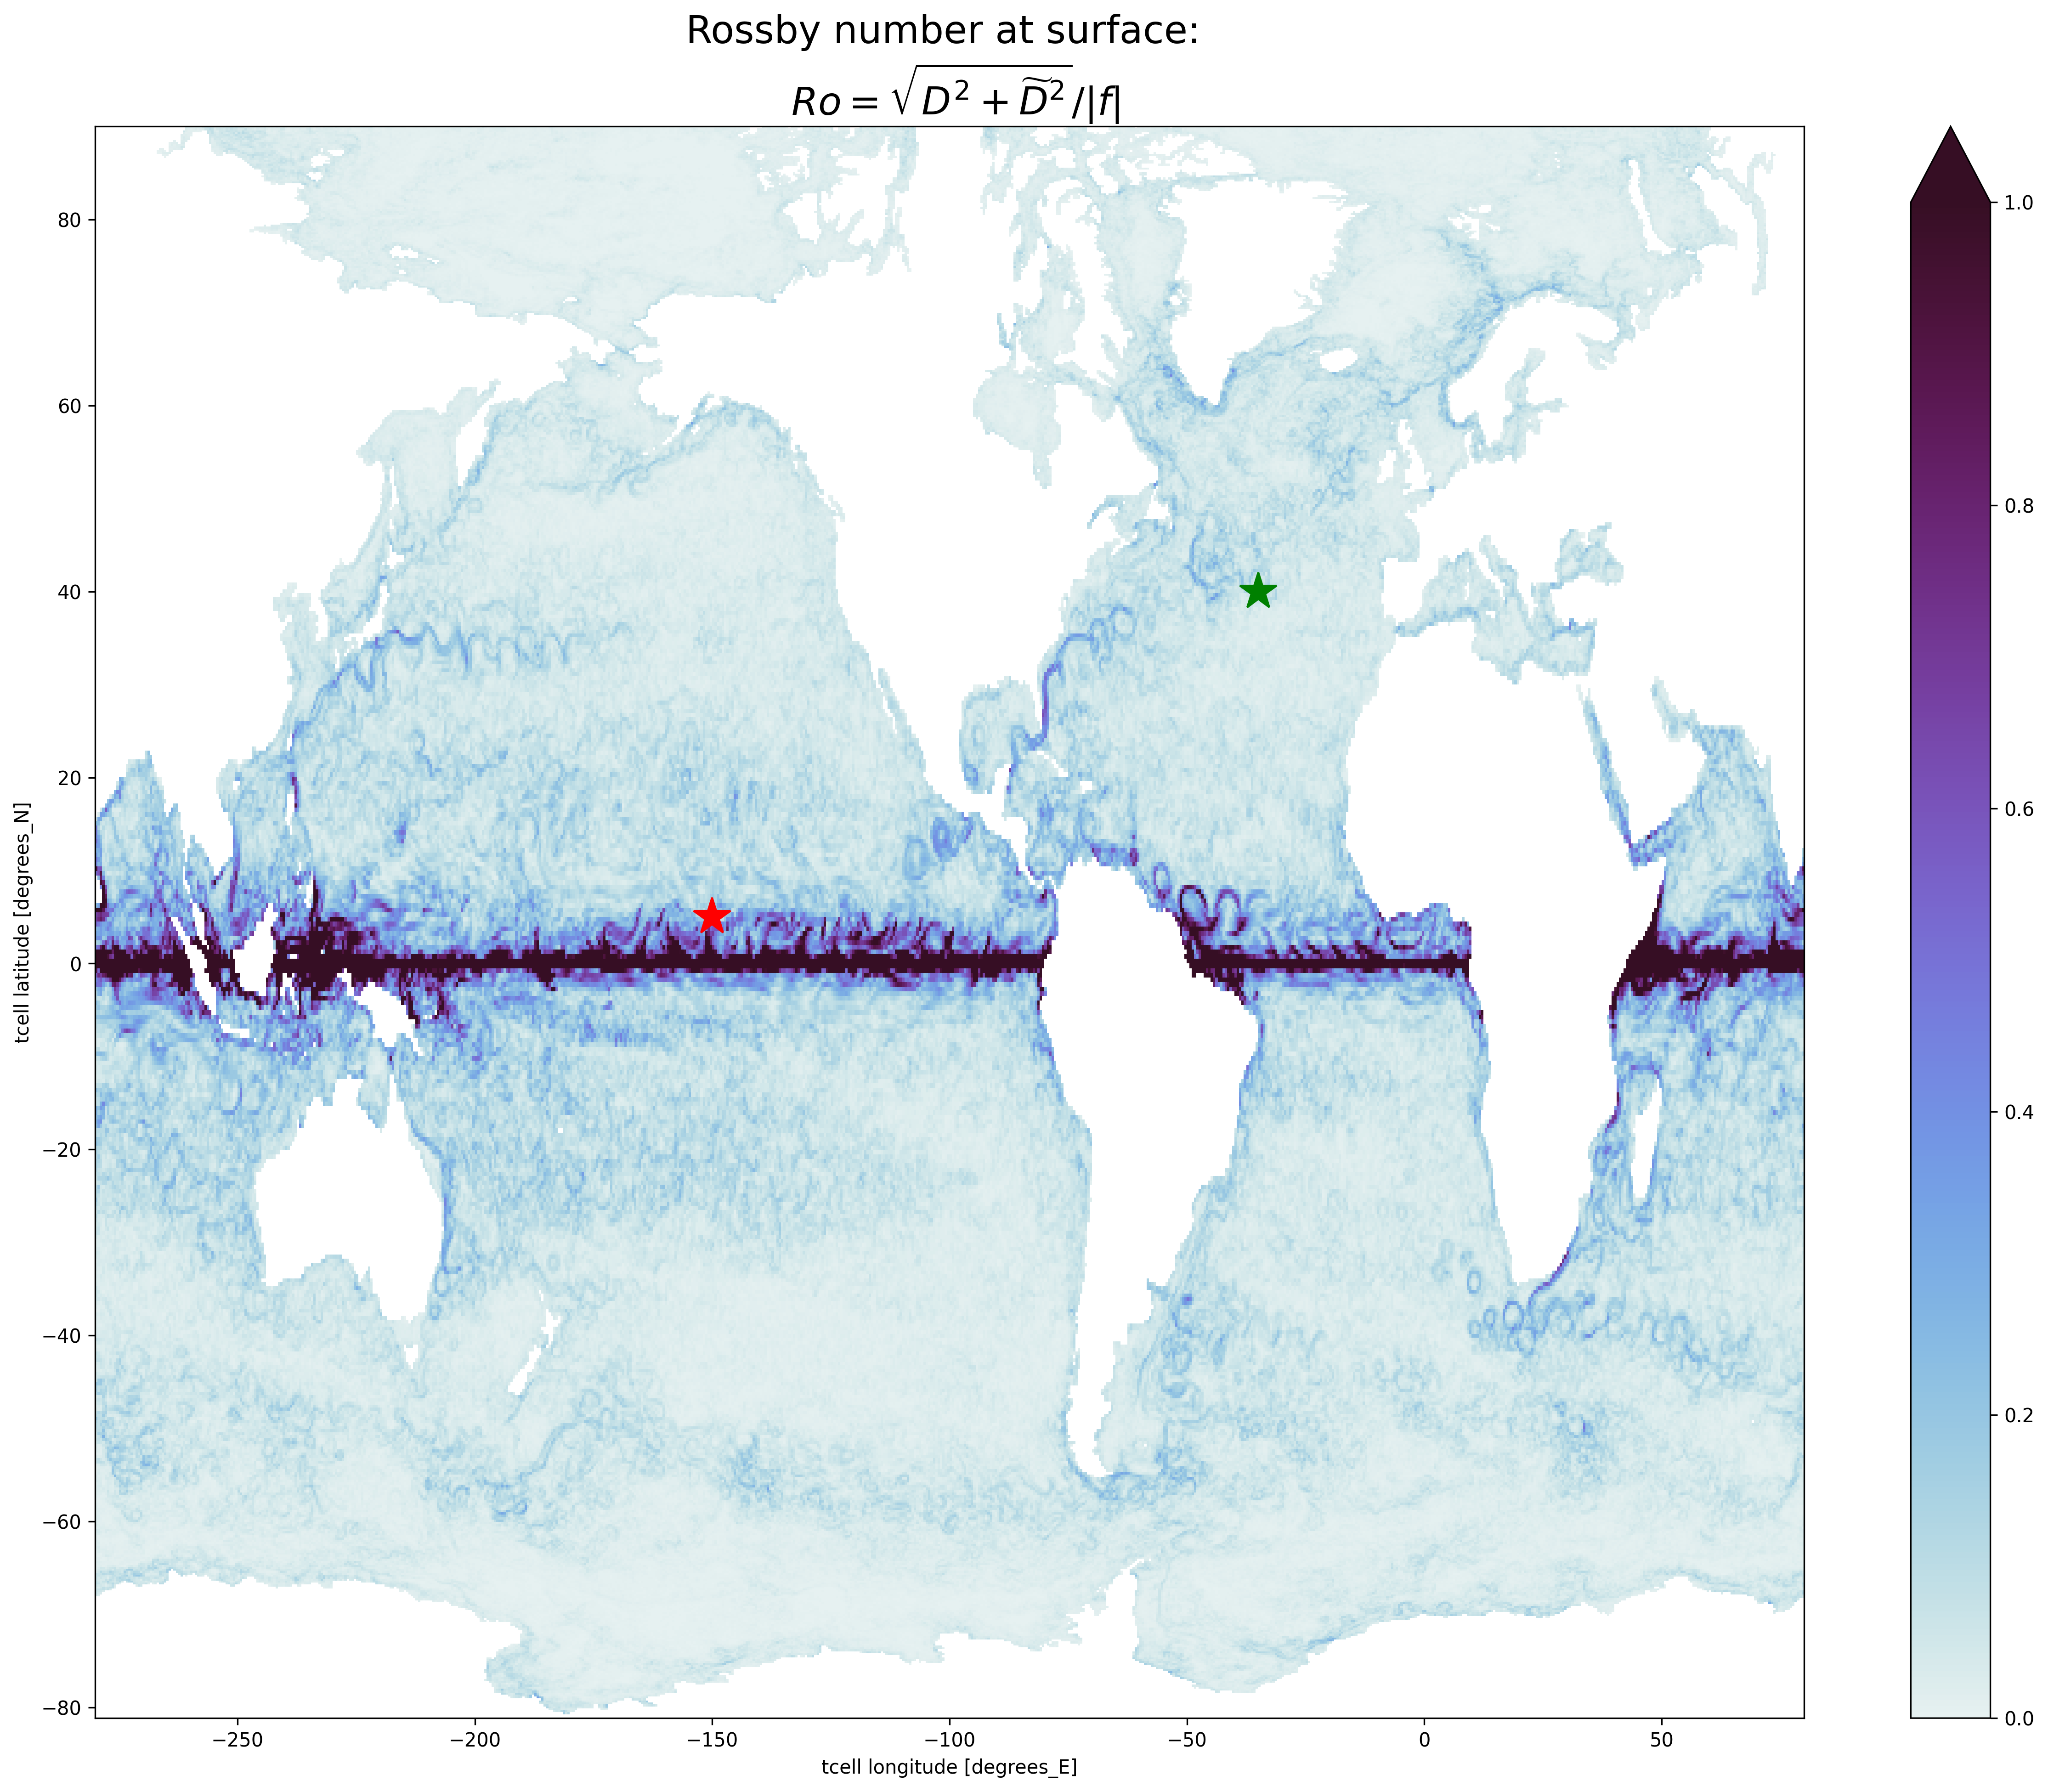

In [37]:
plt.figure(figsize=(20,15), dpi=300)
ro.isel(zl=0).plot(cmap=cmocean.cm.dense, vmax=1)
plt.title('Rossby number at surface: \n $Ro=\sqrt{D^2+\widetilde{D}^2} / |f|$', fontsize=20)
plt.plot(-35,40, '*g',markersize=20)
plt.plot(-150,5, '*r',markersize=20)

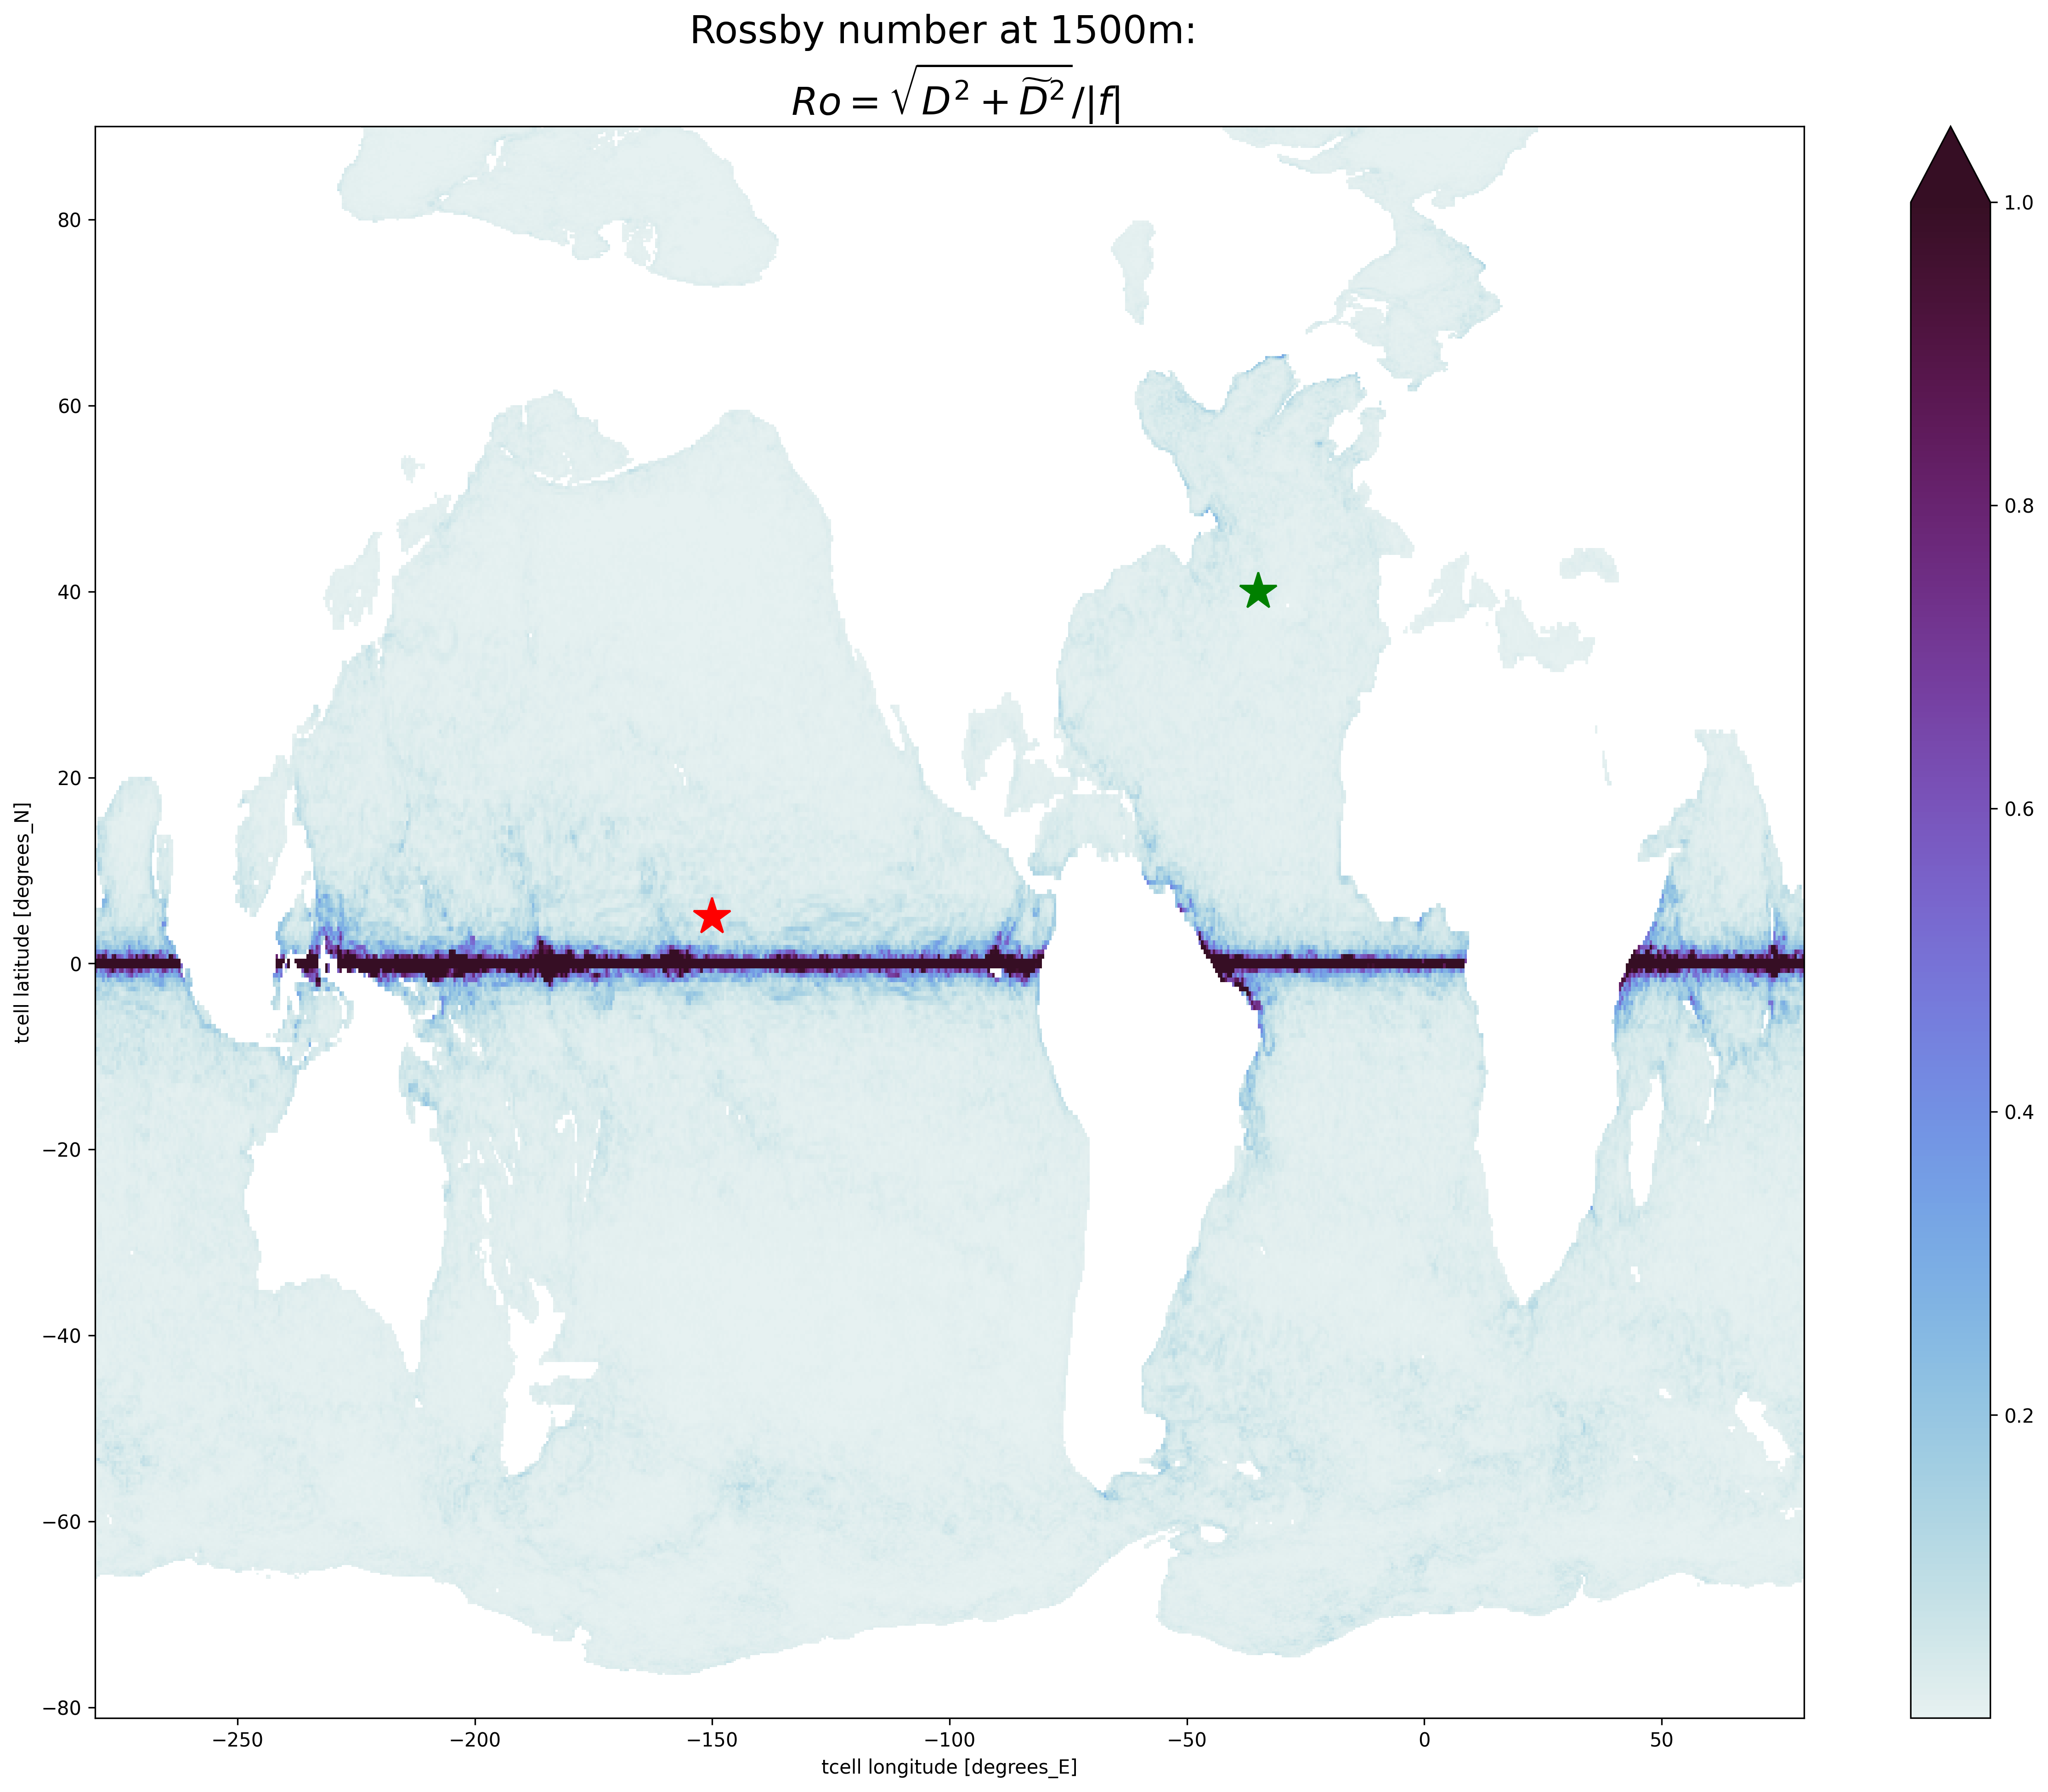

In [38]:
plt.figure(figsize=(20,15), dpi=300)
ro.isel(zl=30).plot(cmap=cmocean.cm.dense, vmax=1)
plt.title('Rossby number at 1500m: \n $Ro=\sqrt{D^2+\widetilde{D}^2} / |f|$', fontsize=20)
plt.plot(-35,40, '*g',markersize=20)
plt.plot(-150,5, '*r',markersize=20)

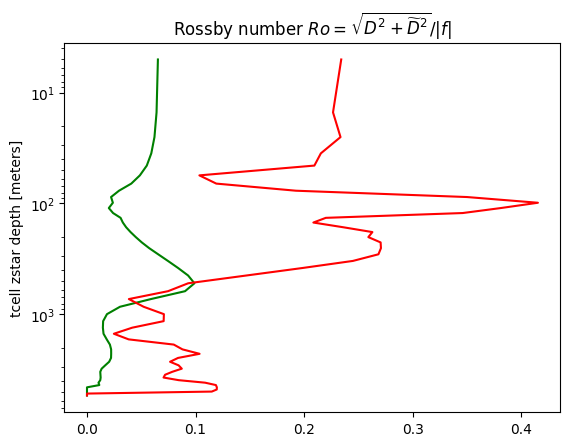

In [39]:
Ro.sel(xh=-35, yh=40, method='nearest').plot(color='g', y='zl')
Ro.sel(xh=-150, yh=5, method='nearest').plot(color='r', y='zl')
plt.title('Rossby number $Ro=\sqrt{D^2+\widetilde{D}^2} / |f|$')
plt.gca().invert_yaxis()
plt.yscale('log')

In [40]:
rr = (Ro * mask).values.ravel()
rr = rr[~np.isnan(rr)];

Text(0.5, 0, 'Ro')

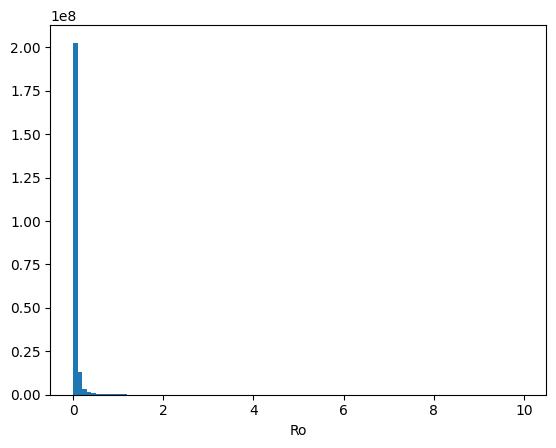

In [41]:
plt.hist(rr, bins=100, range=[0,10]);
#plt.yscale('log')
plt.xlabel('Ro')

In [42]:
plt.hist(1/(1+rr), bins=100, range=[0,1]);
#plt.yscale('log')
plt.xlabel('1/(1+Ro)')

Text(0.5, 0, '1/(1+Ro)')

Text(0.5, 0, 'log10(Ro)')

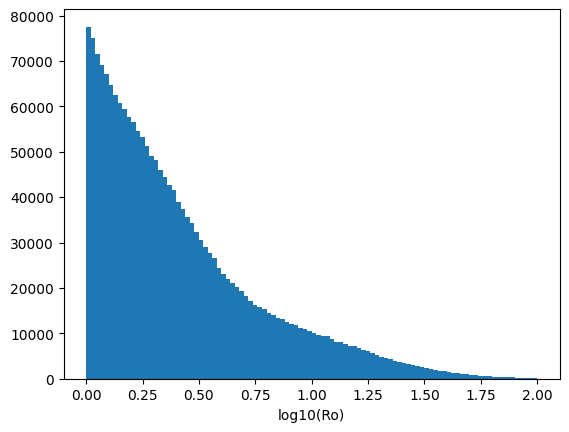

In [43]:
plt.hist(np.log10(rr), bins=100, range=[0,2]);
plt.xlabel('log10(Ro)')

# Vertical grid
Here we show that cell interfaces are located exactly between cell centers, but not vise versa:
\begin{equation}
    z_{k+1/2} = \frac{z_k + z_{k+1}}{2}
\end{equation}
Note that the vertical coordinate in MOM6 is different: it is center cells that are between interfaces:
\begin{equation}
    z_{k} = \frac{z_{k-1/2} + z_{k+1/2}}{2}
\end{equation}

Note that in both formulations of vertical coordinate, the xgcm.diff and xgcm.interp operator works as finite difference operators which do not account for the coordinates

In [45]:
zl = ds.param.zl
zi = ds.param.zi

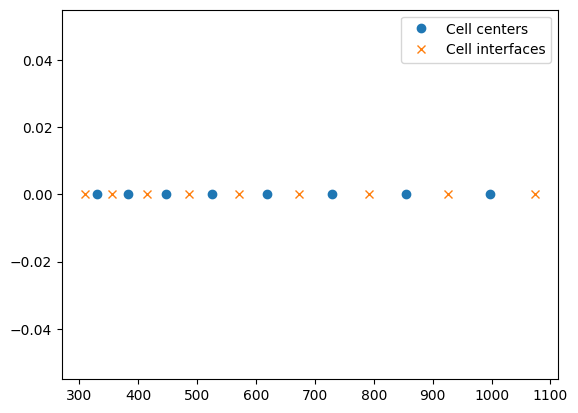

In [51]:
idxl = slice(20,26)
idxi = slice(20,27)
plt.plot(zl[idxl],0*zl[idxl], 'o', label='Cell centers')
plt.plot(zi[idxi],0*zi[idxi], 'x', label='Cell interfaces')
plt.legend()

In [75]:
zl.rolling(zl=2).mean().values - zi[:-1].values

array([            nan,  2.38418579e-07,  4.76837158e-07,  9.53674316e-07,
        1.90734863e-06, -1.90734863e-06,  0.00000000e+00, -3.81469727e-06,
       -3.81469727e-06,  3.81469727e-06,  0.00000000e+00,  0.00000000e+00,
        3.81469727e-06, -7.62939453e-06, -7.62939453e-06,  0.00000000e+00,
        0.00000000e+00,  7.62939453e-06,  0.00000000e+00, -1.52587891e-05,
        0.00000000e+00,  0.00000000e+00,  1.52587891e-05, -1.52587891e-05,
        0.00000000e+00,  3.05175781e-05,  3.05175781e-05,  3.05175781e-05,
        3.05175781e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -6.10351562e-05,  0.00000000e+00,  0.00000000e+00,
       -1.22070312e-04, -1.22070312e-04,  0.00000000e+00,  0.00000000e+00,
       -1.22070312e-04,  0.00000000e+00,  0.00000000e+00, -1.22070312e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [76]:
zi.rolling(zi=2).mean()[1:].values - zl.values

array([0.00000000e+00, 1.28998756e-02, 5.09929657e-03, 1.96981430e-02,
       1.47495270e-02, 3.29017639e-02, 3.31516266e-02, 5.82542419e-02,
       6.80503845e-02, 1.06647491e-01, 1.34399414e-01, 1.97849274e-01,
       2.59048462e-01, 3.67263794e-01, 4.87899780e-01, 6.72950745e-01,
       8.90945435e-01, 1.19414520e+00, 1.54795837e+00, 1.99356079e+00,
       2.47509766e+00, 3.00099182e+00, 3.47369385e+00, 3.86616516e+00,
       4.06704712e+00, 4.07809448e+00, 3.85504150e+00, 3.48474121e+00,
       2.98992920e+00, 2.48614502e+00, 1.98254395e+00, 1.55889893e+00,
       1.18322754e+00, 9.01916504e-01, 6.62109375e-01, 4.98657227e-01,
       3.56811523e-01, 2.69653320e-01, 1.87377930e-01, 1.44653320e-01,
       9.68017578e-02, 7.78808594e-02, 4.83398438e-02, 4.34570312e-02,
       2.24609375e-02, 2.51464844e-02, 9.52148438e-03, 1.51367188e-02,
       2.68554688e-03, 1.04980469e-02])

In [77]:
grid = ds.grid

In [82]:
grid.diff(zi,'Z') - np.diff(zi)

<xarray.DataArray 'zi' (zl: 50)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * zl       (zl) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03

In [97]:
grid.interp(zi,'Z').values - (zi).rolling(zi=2).mean()[1:].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:
grid.diff(zl,'Z')[1:-1] - np.diff(zl)

<xarray.DataArray 'zl' (zi: 49)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * zi       (zi) float64 10.07 20.16 30.29 40.47 ... 4.87e+03 5.08e+03 5.29e+03

In [99]:
grid.interp(zi,'Z').values - (zi).rolling(zi=2).mean()[1:].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [110]:
grid.interp(zl,'Z')[1:-1].values - zl.rolling(zl=2).mean()[1:].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Vertical structure solver on idealized profiles

In [80]:
N2 = np.arange(3)+1
dzB = np.ones(3)
dzT = np.ones(4)
D, eigenValues, eigenVectors = vertical_modes_one_column(N2, dzB, dzT, dirichlet_surface=True, dirichlet_bottom=True, debug=True)

Eigenvalues in descending order: [-0.22744788 -0.68883592 -1.25239161 -2.83132458]
Error in Eigendecomposition norm(D - V*L*V^T)/norm(D): 1.8388468997806305e-15
Error in eigenvectors orthogonality: norm(V*V^T-E)/norm(E), norm(V^T*V-E)/norm(E): 8.701242344665378e-16 8.994610546077e-16
Every vector is properly shaped: norm(D*v_1 - eigval_1*v_1)/norm(v_1): 5.225867067904714e-16


In [439]:
Npoints = 100
zi = np.linspace(0,-1,Npoints)
zl = (zi[0:-1] + zi[1:])/2
dz = np.diff(zi)[0]
zi = zi[1:-1]

N2 = np.exp(5*zi)
dzB = np.ones(Npoints-2)
dzT = np.ones(Npoints-1)

plt.subplot(1,2,1)
plt.plot(N2,zi,lw=3)
plt.ylabel('Depth')
plt.title('Stratification profile, $N^2$')
plt.grid()
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,0.1])

plt.subplot(1,2,2)
modes, cg = vertical_modes_one_column(N2, dzB, dzT, dirichlet_surface=True, dirichlet_bottom=False, few_modes=3)
plt.plot(modes,zl,lw=3)
plt.ylabel('Depth')
plt.title('W. Zhang 2024 (Interior modes)')
plt.grid()
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,0.1])

plt.tight_layout()

# Vertical structure solver on realistic data

In [65]:
%time modes, cg = ds.state.vertical_modes(dirichlet_bottom=False, dirichlet_surface=False, few_modes=1)

CPU times: user 25 s, sys: 9.71 s, total: 34.7 s
Wall time: 20.8 s


In [66]:
modes.plot(y='zl')
plt.gca().invert_yaxis()

In [67]:
cg

array([2.29843312])

In [68]:
%%time 
ds.state.baroclinic_speed.sel(xh=0, yh=0, method='nearest').isel(time=0).values

CPU times: user 27.4 s, sys: 11.3 s, total: 38.8 s
Wall time: 24.1 s


array(2.53125457)

# Extend analysis to spatial maps

In [148]:
%%time 
coarse = ds.coarsen(10)

CPU times: user 19.8 s, sys: 2.24 s, total: 22 s
Wall time: 21.4 s


In [149]:
%time cg_wkb = coarse.state.baroclinic_speed.isel(time=0).compute()

CPU times: user 13.7 s, sys: 3.95 s, total: 17.7 s
Wall time: 4.95 s


Text(0.5, 1.0, 'Baroclinic speed, WKB approximation, m/s')

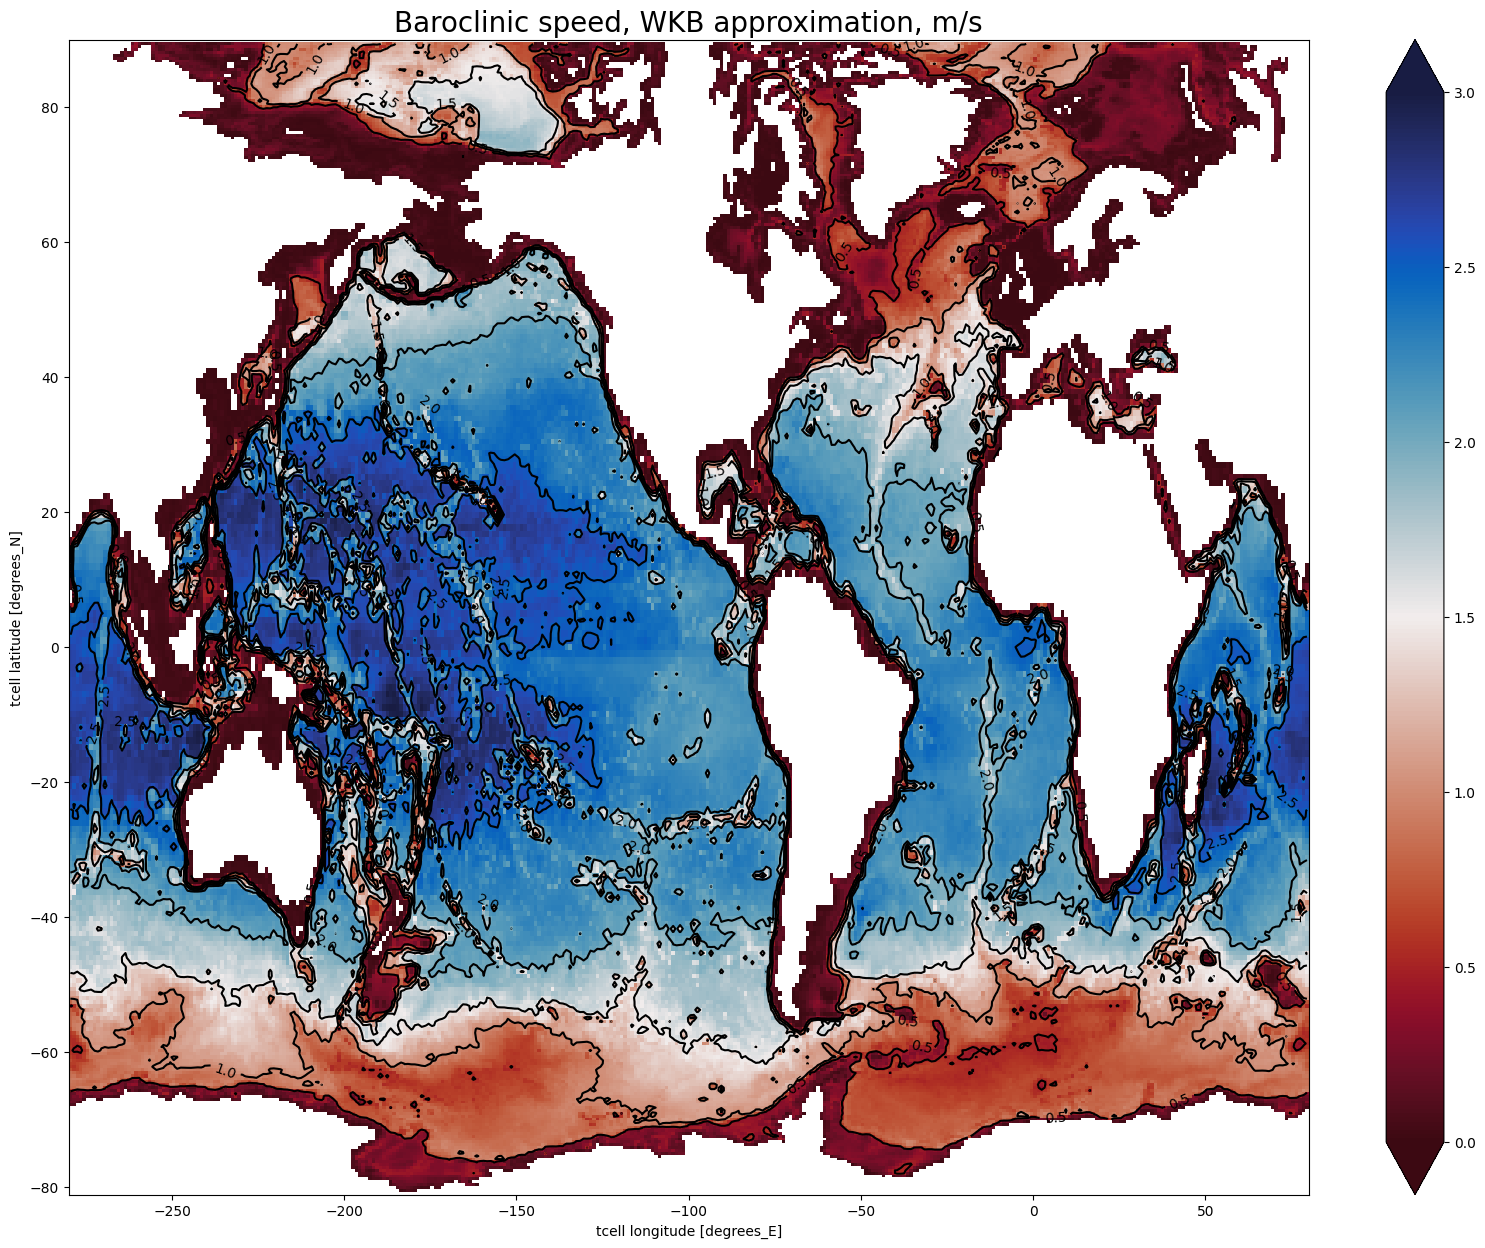

In [177]:
plt.figure(figsize=(20,15))
import cmocean
mask = coarse.param.wet[0]
mask = np.where(mask,1,np.nan)

cg_wkb = (cg_wkb*mask)

(cg_wkb).plot(cmap=cmocean.cm.balance.reversed(),extend='both', vmax=3, vmin=0)
CS = (cg_wkb).plot.contour(colors='k', levels=np.arange(0,4,0.5))
plt.clabel(CS)
plt.title('Baroclinic speed, WKB approximation, m/s', fontsize=20)

In [195]:
%time modes, cg = coarse.state.vertical_modes_map(few_modes=2, dirichlet_bottom=True, dirichlet_surface=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
CPU times: user 2min 34s, sys:

Text(0.5, 1.0, 'Baroclinic speed, Shafer 2007, m/s')

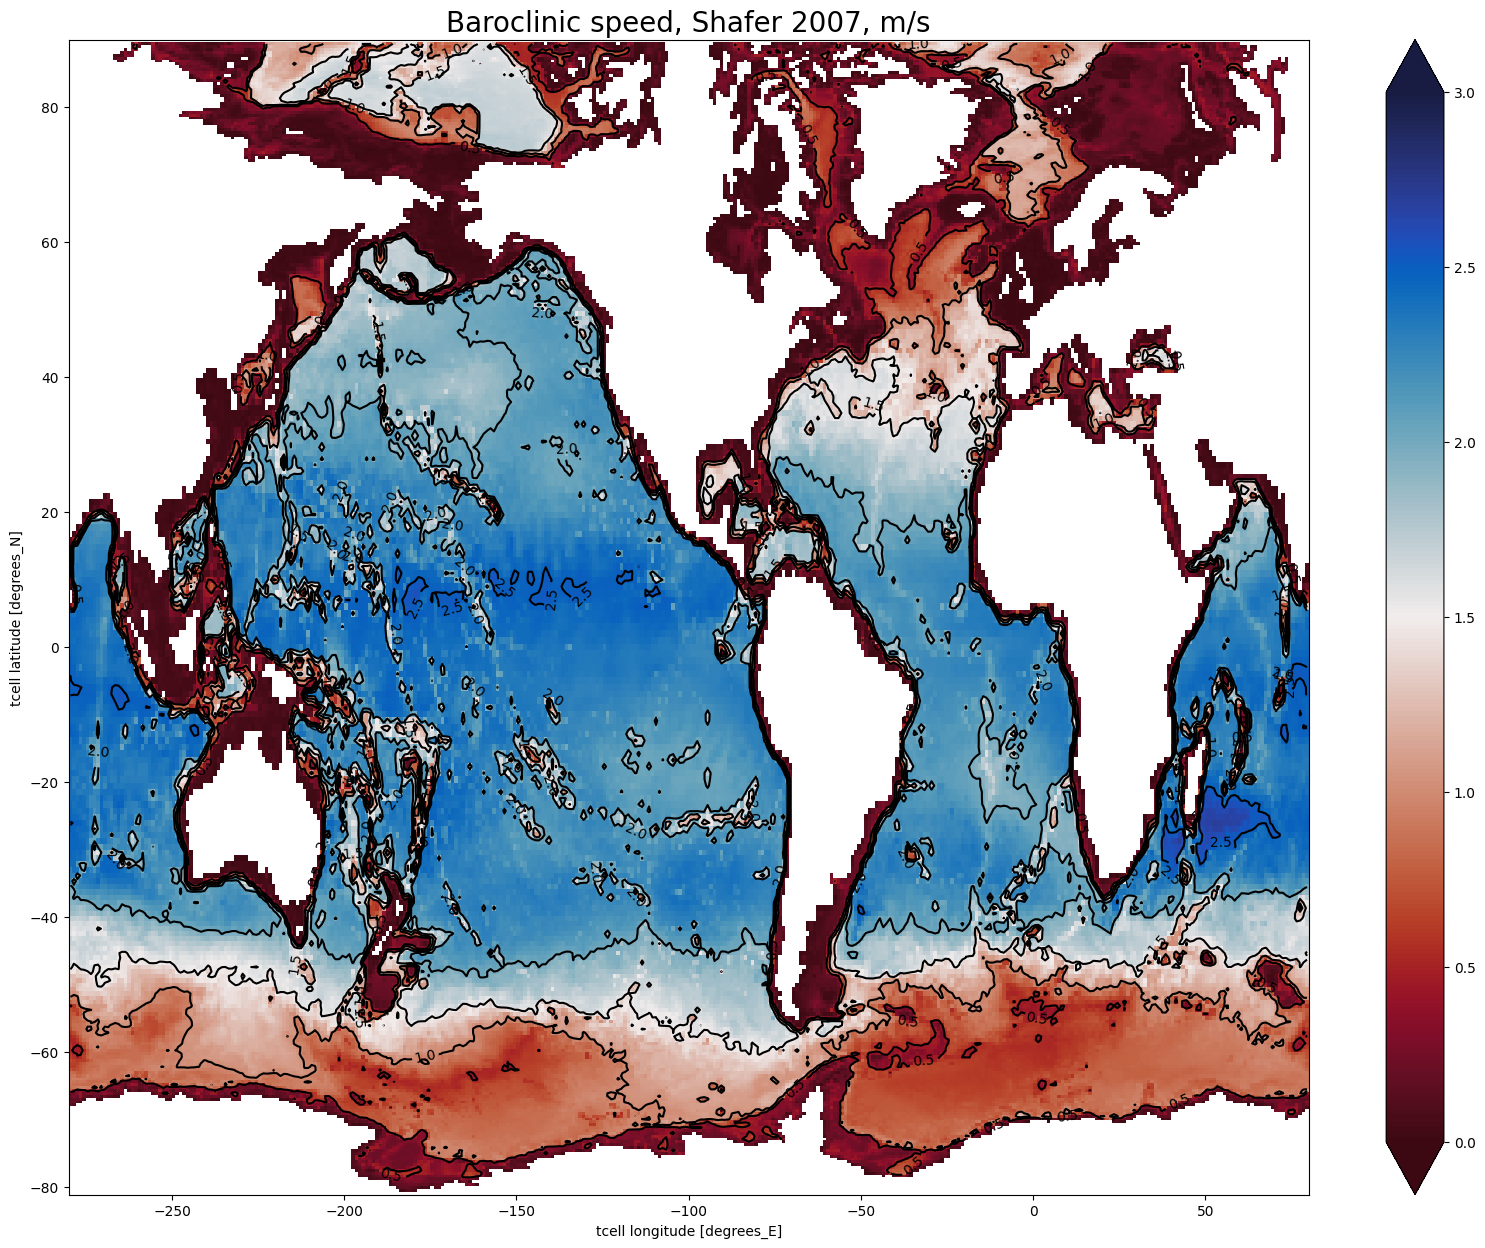

In [199]:
plt.figure(figsize=(20,15))
import cmocean
mask = coarse.param.wet[0]
mask = np.where(mask,1,np.nan)

Cg = (cg.isel(mode=0)*mask)

(Cg).plot(cmap=cmocean.cm.balance.reversed(),extend='both', vmin=0, vmax=3)
CS = (Cg).plot.contour(colors='k', levels=np.arange(0,4,0.5))
plt.clabel(CS)
plt.title('Baroclinic speed, Shafer 2007, m/s', fontsize=20)

# Deriving WKB approximations

In [55]:
def plot(Npoints = 100, high_order_dirichlet=True, few_modes=3, profile='flat', scales=[1e+1,1e+2,1e+3]):
    zi = np.linspace(0,-1,Npoints)
    zl = (zi[0:-1] + zi[1:])/2
    dz = -np.diff(zi)[0]
    zi = zi[1:-1]

    if profile == 'flat':
        N2 = 0.1*np.ones(len(zi))
    elif profile == 'exp':
        N2 = np.exp(5*zi)
    dzB = dz * np.ones(Npoints-2)
    dzT = dz * np.ones(Npoints-1)

    plt.figure(figsize=(10,10))
    plt.subplot(2,3,1)
    plt.plot(N2,zi, lw=3, color='r')
    plt.xlabel('$N^2$')
    plt.ylabel('Depth, $z/H$')
    plt.title('Stratification profile')
    plt.grid()
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    kw = dict(N2=N2, dzB=dzB, dzT=dzT, few_modes=few_modes, high_order_dirichlet=high_order_dirichlet)
    
    plt.subplot(2,3,2)
    modes, cg = vertical_modes_one_column(dirichlet_surface=True, dirichlet_bottom=True, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(dirichlet_surface=True, dirichlet_bottom=True, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.title('Chelton 1998 \n(rigid lid)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.subplot(2,3,3)
    modes, cg = vertical_modes_one_column(dirichlet_surface=False, dirichlet_bottom=False, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(dirichlet_surface=False, dirichlet_bottom=False, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.title('Smith 2007 \n(Flat-bottom)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.subplot(2,3,4)
    modes, cg = vertical_modes_one_column(dirichlet_surface=False, dirichlet_bottom=True, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(dirichlet_surface=False, dirichlet_bottom=True, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.ylabel('Depth, $z/H$')
    plt.title('Yankovsky 2023 \n(Rough-bottom)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.subplot(2,3,5)
    modes, cg = vertical_modes_one_column(dirichlet_surface=True, dirichlet_bottom=False, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(dirichlet_surface=True, dirichlet_bottom=False, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.title('W. Zhang 2024 \n(Interior modes)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])

    plt.subplot(2,3,6)
    modes = vertical_modes_one_column(SQG=True, scales=scales, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(SQG=True, scales=scales, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.title('W. Zhang 2024 \n(SQG, i.e. Surface-trapped)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.tight_layout()

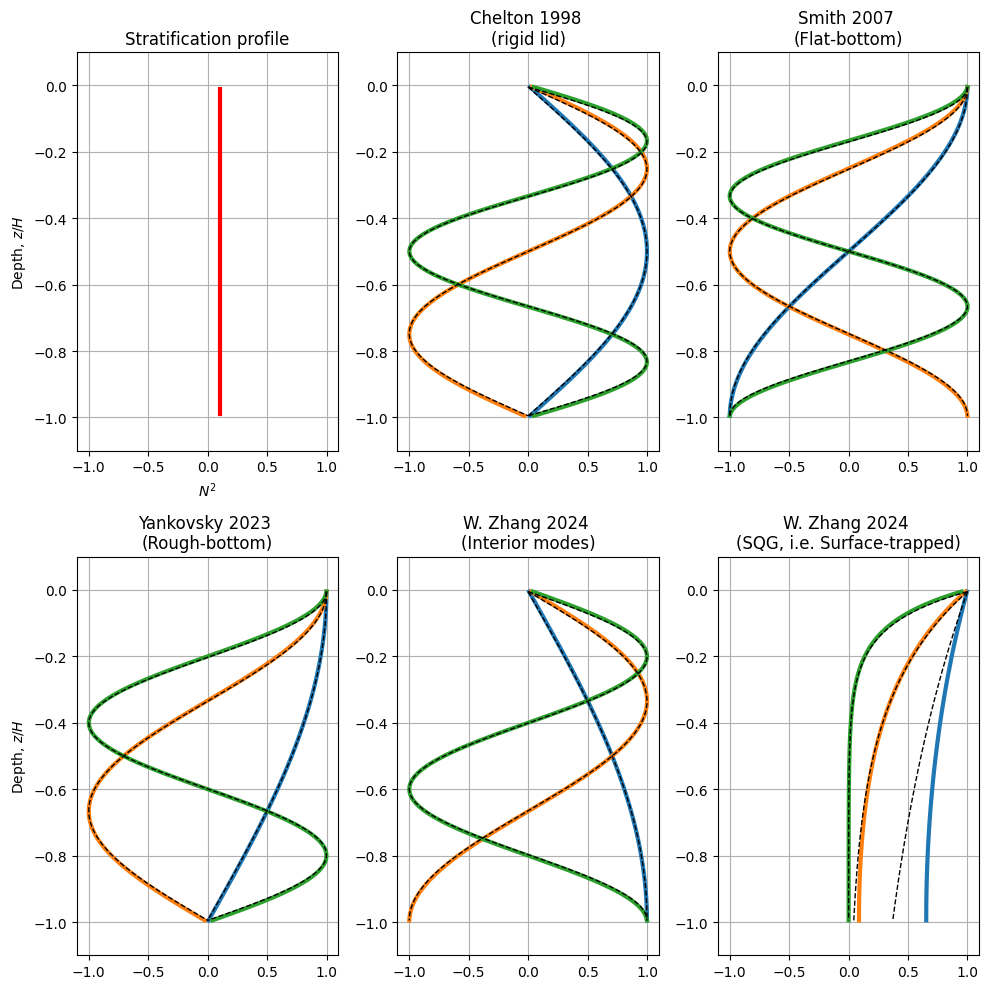

In [56]:
plt.rcParams["font.size"] = 10
plot()

# Testing WKB approximations

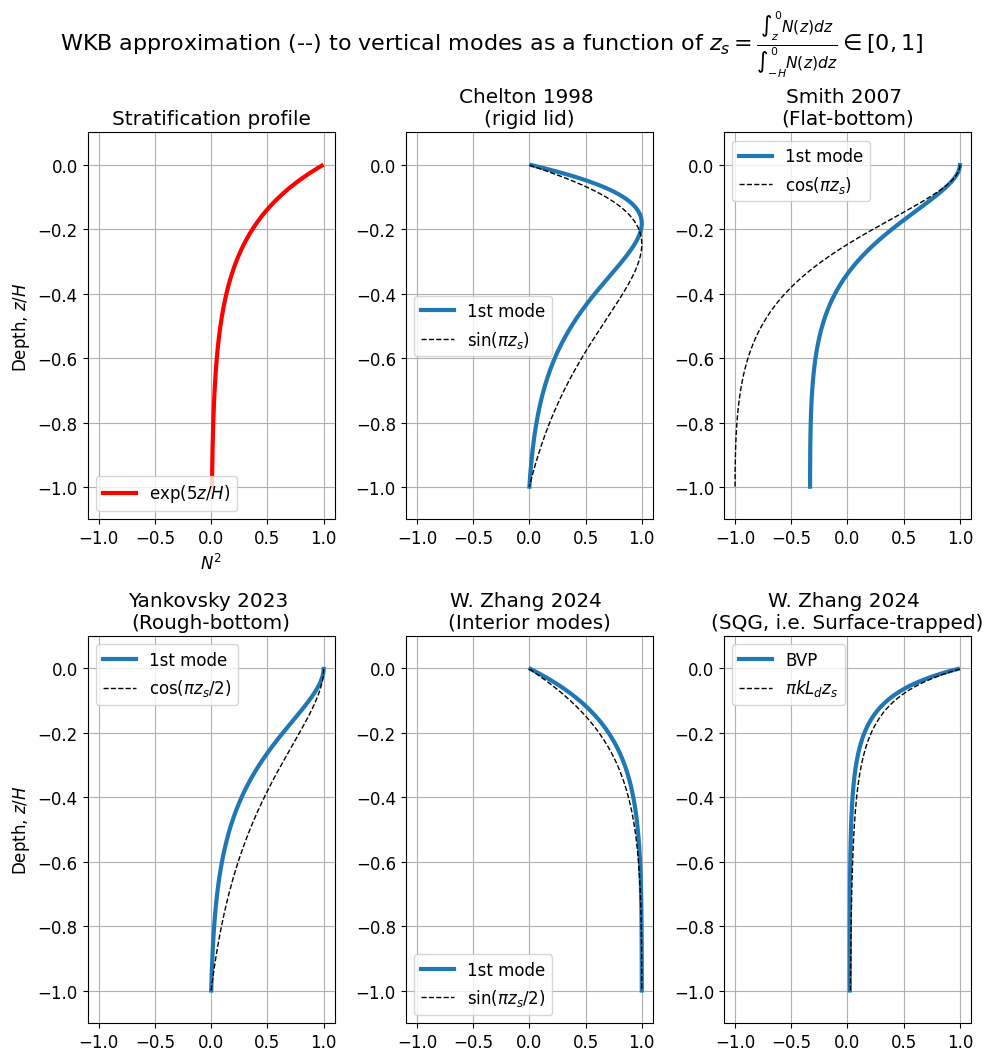

In [57]:
plt.rcParams["font.size"] = 12
plot(Npoints=300, scales=[1e+2], profile='exp', few_modes=1)

plt.subplot(2,3,1)
plt.plot(np.nan,np.nan,lw=3,color='r', label='$\exp(5z/H)$')
plt.legend(loc='lower left')

plt.subplot(2,3,2)
plt.plot(np.nan,np.nan,lw=3,color='tab:blue',label='1st mode')
plt.plot(np.nan,np.nan,lw=1,color='k', ls='--', label='$\sin(\pi z_s)$')
plt.legend(loc='best')

plt.subplot(2,3,3)
plt.plot(np.nan,np.nan,lw=3,color='tab:blue',label='1st mode')
plt.plot(np.nan,np.nan,lw=1,color='k', ls='--', label='$\cos(\pi z_s)$')
plt.legend(loc='best')

plt.subplot(2,3,4)
plt.plot(np.nan,np.nan,lw=3,color='tab:blue',label='1st mode')
plt.plot(np.nan,np.nan,lw=1,color='k', ls='--', label='$\cos(\pi z_s/2)$')
plt.legend(loc='best')

plt.subplot(2,3,5)
plt.plot(np.nan,np.nan,lw=3,color='tab:blue',label='1st mode')
plt.plot(np.nan,np.nan,lw=1,color='k', ls='--', label='$\sin(\pi z_s/2)$')
plt.legend(loc='best')

plt.subplot(2,3,6)
plt.plot(np.nan,np.nan,lw=3,color='tab:blue',label='BVP')
plt.plot(np.nan,np.nan,lw=1,color='k', ls='--', label='$\pi k L_d z_s$')
plt.legend(loc='best')

plt.suptitle('WKB approximation (--) to vertical modes as a function of $z_s=\\frac{\int_{z}^{0} N(z)dz}{\int_{-H}^{0} N(z)dz}\in[0,1]$', 
             y=1.06, fontsize=16)
plt.savefig('WKB_exp.pdf',bbox_inches='tight')

# Here we show that both implementations of boundary conditions are equal to each other with very accurate grid

In [83]:
for Npoints in [5, 10, 100, 500, 1000]:
    zi = np.linspace(0,-1,Npoints)
    zl = (zi[0:-1] + zi[1:])/2
    dz = -np.diff(zi)[0]
    zi = zi[1:-1]
    
    N2 = np.exp(5*zi)
    dzB = dz * np.ones(Npoints-2)
    dzT = dz * np.ones(Npoints-1)
    
    modes_high, cg_high = vertical_modes_one_column(N2, dzB, dzT, dirichlet_surface=True, dirichlet_bottom=True, few_modes=3, high_order_dirichlet=True)
    modes_low, cg_low = vertical_modes_one_column(N2, dzB, dzT, dirichlet_surface=True, dirichlet_bottom=True, few_modes=3, high_order_dirichlet=False)
    print('Wave speed:', cg)
    print('Error in wave speeds:', np.linalg.norm(cg_high-cg_low) / np.linalg.norm(cg_low))
    print('Error in profile:', np.linalg.norm(modes_high - modes_low) / np.linalg.norm(modes_low))
    print('\n')

Wave speed: [0.12512551 0.06245478 0.04279821]
Error in wave speeds: 0.16488150268895232
Error in profile: 0.2488734511995952


Wave speed: [0.12512551 0.06245478 0.04279821]
Error in wave speeds: 0.09680903239575768
Error in profile: 0.3068718716177533


Wave speed: [0.12512551 0.06245478 0.04279821]
Error in wave speeds: 0.012871576499247849
Error in profile: 0.048677143300418786


Wave speed: [0.12512551 0.06245478 0.04279821]
Error in wave speeds: 0.002687155346663249
Error in profile: 0.010303030723949095


Wave speed: [0.12512551 0.06245478 0.04279821]
Error in wave speeds: 0.0013510535763337766
Error in profile: 0.0051907771226643




# Applying WKB approximation to real data

In [131]:
def plot(high_order_dirichlet=True, few_modes=1, scales=[1]):
    plt.figure(figsize=(10,10))
    
    plt.subplot(2,3,1)
    plt.plot(np.sqrt(N2),zi, lw=3, color='r')
    plt.xlabel('$N$, $1/s$')
    plt.ylabel('Depth, $z$')
    plt.title('Stratification profile')
    plt.grid()
    #plt.xlim([-1.1,1.1])
    #plt.ylim([-1.1,0.1])
    #plt.xticks([-1,-0.5,0,0.5,1])
    
    kw = dict(N2=N2, dzB=dzB, dzT=dzT, few_modes=few_modes, high_order_dirichlet=high_order_dirichlet)
    
    plt.subplot(2,3,2)
    modes, cg = vertical_modes_one_column(dirichlet_surface=True, dirichlet_bottom=True, **kw)
    modes_wkb, z_s = vertical_modes_one_column_WKB(dirichlet_surface=True, dirichlet_bottom=True, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    #plt.plot(z_s,zl,lw=1, color='k', ls='-.')
    plt.title('Chelton 1998 \n(rigid lid)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    #plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.subplot(2,3,3)
    modes, cg = vertical_modes_one_column(dirichlet_surface=False, dirichlet_bottom=False, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(dirichlet_surface=False, dirichlet_bottom=False, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.title('Smith 2007 \n(Flat-bottom)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    #plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.subplot(2,3,4)
    modes, cg = vertical_modes_one_column(dirichlet_surface=False, dirichlet_bottom=True, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(dirichlet_surface=False, dirichlet_bottom=True, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.ylabel('Depth, $z$')
    plt.title('Yankovsky 2023 \n(Rough-bottom)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    #plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.subplot(2,3,5)
    modes, cg = vertical_modes_one_column(dirichlet_surface=True, dirichlet_bottom=False, **kw)
    modes_wkb, z_s = vertical_modes_one_column_WKB(dirichlet_surface=True, dirichlet_bottom=False, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.plot(z_s,zl,lw=1, color='k', ls=':')
    plt.title('W. Zhang 2024 \n(Interior modes)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    #plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])

    plt.subplot(2,3,6)
    modes = vertical_modes_one_column(SQG=True, scales=scales, **kw)
    modes_wkb, _ = vertical_modes_one_column_WKB(SQG=True, scales=scales, **kw)
    plt.plot(modes,zl,lw=3)
    plt.plot(modes_wkb,zl,lw=1, color='k', ls='--')
    plt.title('W. Zhang 2024 \n(SQG, i.e. Surface-trapped)')
    plt.grid()
    plt.xlim([-1.1,1.1])
    #plt.ylim([-1.1,0.1])
    plt.xticks([-1,-0.5,0,0.5,1])
    
    plt.tight_layout()

In [ ]:
plt.plot(0,0, '*g',markersize=50, markeredgecolor='w')
plt.plot(-200, 30, '*g',markersize=50, markeredgecolor='w')
plt.plot(-50, 30, '*g',markersize=50, markeredgecolor='w')
plt.plot(-50, -60, '*g',markersize=50, markeredgecolor='w')
plt.plot(-200, 80, '*g',markersize=50, markeredgecolor='w')
plt.title('Rossby deformation radius in km', fontsize=20)

In [149]:
%time N2, dzB, dzT, zi, zl = ds.state.vertical_modes(lon=-200, lat=80)

CPU times: user 25.5 s, sys: 8.89 s, total: 34.4 s
Wall time: 19.9 s


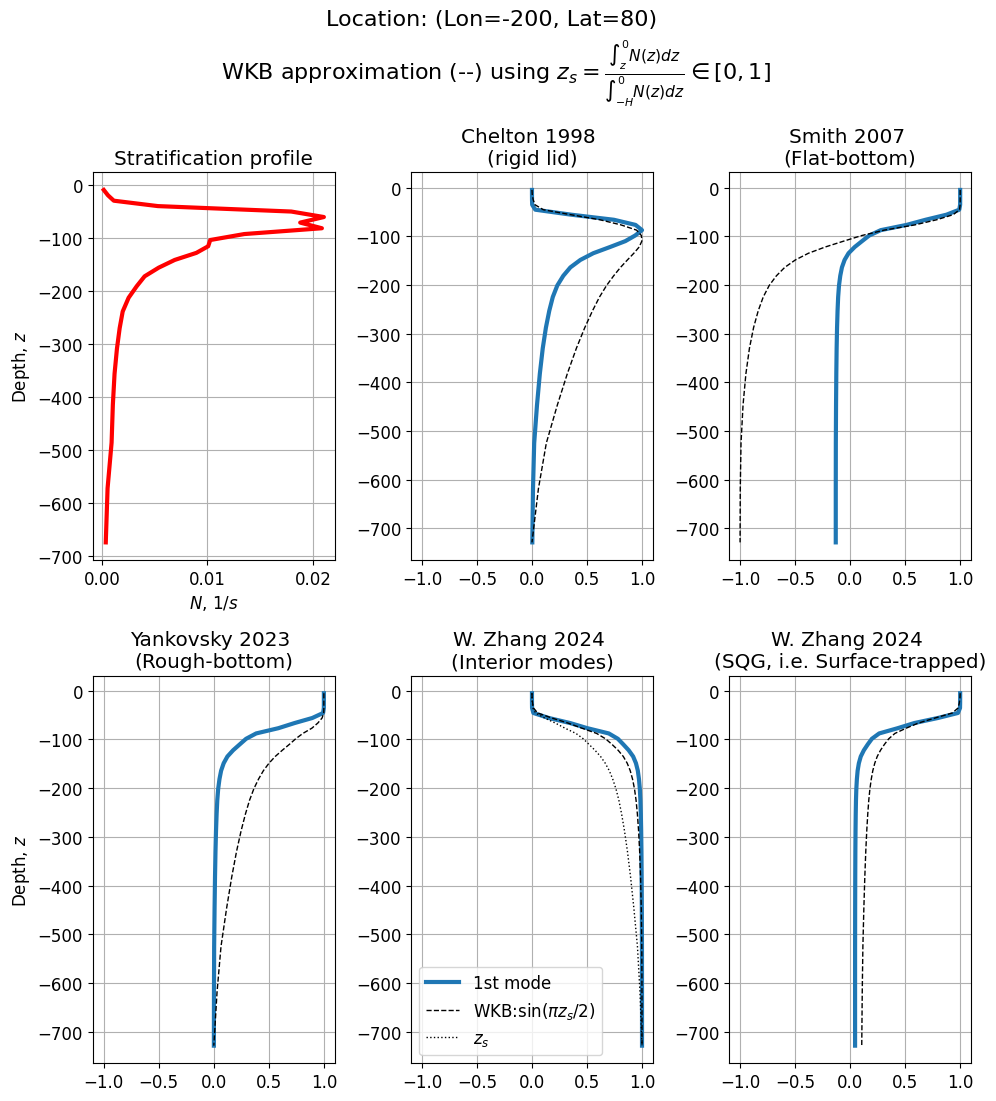

In [150]:
plot(few_modes=1)
plt.suptitle('Location: (Lon=-200, Lat=80)\n WKB approximation (--) using $z_s=\\frac{\int_{z}^{0} N(z)dz}{\int_{-H}^{0} N(z)dz}\in[0,1]$', 
             y=1.1, fontsize=16)
plt.subplot(2,3,5)
plt.plot(np.nan, np.nan, lw=3, color='tab:blue', label='1st mode')
plt.plot(np.nan,np.nan,lw=1,color='k', ls='--', label='WKB:$\sin(\pi z_s/2)$')
plt.plot(np.nan,np.nan,lw=1,color='k', ls=':', label='$z_s$')
plt.legend()

plt.savefig('WKB_Lon-200_Lat-80.pdf',bbox_inches='tight')